# To do:

- ~~Dataset class~~
- ~~GNN class~~
- ~~Train function~~
- ~~Validation function~~
- ~~Run single test training~~
- ~~Fine tune HP with CV~~
- ~~Extract CV score~~

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import random
#from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import dense_to_sparse
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch.functional import F
from sklearn.model_selection import KFold, train_test_split
import copy
import time

In [2]:
# Mount drive
# from google.colab import drive
# drive.mount('/content/drive')
RSEED=42

In [3]:
# Current path
#path = '/content/drive/MyDrive/Colab Notebooks/Work/Reactors/Pseudomonas Reactor/'
path = ''

## Import Bioreactors data

In [4]:
RSEED = 42
np.random.seed(RSEED)
torch.manual_seed(RSEED);

In [5]:
# Load bioreactor data
full_sheet = pd.ExcelFile(path + 'BioreactorPsdmData.xlsx')
df_adip7d  = pd.read_excel(full_sheet, 'bioreactors 7d')
df_lostbio7d  = pd.read_excel(full_sheet, 'lost biomass 7d')

# Group the dataframe by 'reactor'
reactor_dfs = {name: group.reset_index(drop=True) for name, group in df_adip7d.groupby('reactor')}

# Get list of reactor keys and shuffle
reactor_keys = list(reactor_dfs.keys())
random.shuffle(reactor_keys)

for key in reactor_keys:
    reactor_dfs[key] = reactor_dfs[key].sample(frac=1).reset_index(drop=True)

In [6]:
df_adip7d

,reactor,media,glucose,flow_rate_microL,flow_rate,cychl,time,adipic_acid,out_biomass,out_biomas_dg
0,Reactor_1,0.25,2,195,0.195,10,1,0.000000,28.872288,0.288723
1,Reactor_1,0.25,2,195,0.195,10,2,0.093127,35.369568,0.353696
2,Reactor_1,0.25,2,195,0.195,10,3,0.205484,24.178003,0.241780
3,Reactor_1,0.25,2,195,0.195,10,4,0.189075,28.612397,0.286124
4,Reactor_1,0.25,2,195,0.195,10,5,0.169618,28.295654,0.282957
...,...,...,...,...,...,...,...,...,...,...
123,Reactor_16,1.00,2,105,0.105,50,4,0.000000,0.974592,0.009746
124,Reactor_16,1.00,2,105,0.105,50,5,0.000000,1.827360,0.018274
125,Reactor_16,1.00,2,105,0.105,50,6,0.000000,1.595894,0.015959
126,Reactor_16,1.00,2,105,0.105,50,7,0.000000,1.815178,0.018152


## Classes and functions definitions

In [7]:
class ReactorGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim=32, out_dim=2, num_layers=2):
        """
        in_dim: node feature size
        hidden_dim: internal embedding size for nodes / graph
        out_dim: final prediction dim per timestep (e.g. 2)
        num_layers: number of hidden message-passing layers (not counting the first conv)
        """
        super(ReactorGNN, self).__init__()

        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.num_layers = num_layers

        # first conv: in_dim -> hidden_dim
        self.convs = nn.ModuleList([SAGEConv(in_dim, hidden_dim)])

        # add num_layers hidden convs: hidden_dim -> hidden_dim
        for _ in range(num_layers):
            self.convs.append(SAGEConv(hidden_dim, hidden_dim))

        # MLP: maps graph embedding (hidden_dim) -> out_dim
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def encode_graph(self, data):
        # data is a torch_geometric.data.Data object on same device as model
        x, edge_index, batch = data.x, data.edge_index, data.batch

        h = x
        for conv in self.convs:
            h = F.relu(conv(h, edge_index))

        # global pooling -> graph embedding shape (num_graphs_in_batch, hidden_dim)
        g = global_mean_pool(h, batch)  # since batch all zeros, becomes (1, hidden_dim)
        return g

    def forward(self, graph_list):
        """
        Accepts either:
         - graph_list: a list of T Data objects (single reactor)
         - graph_list: a list of B elements, each a list of T Data objects (batch of reactors)

        Returns:
         - if input is single reactor: tensor (T, out_dim)
         - if input is batch of reactors: tensor (B, T, out_dim)
        """

        device = next(self.parameters()).device

        # Detect if this is a batch of reactors or single reactor
        if len(graph_list) == 0:
            return torch.empty(0, self.out_dim, device=device)

        # If first element is a Data object -> treat as single reactor
        first = graph_list[0]
        is_single_reactor = hasattr(first, 'x') and hasattr(first, 'edge_index')

        if is_single_reactor:
            preds = []
            for g in graph_list:
                g = g.to(device)
                embed = self.encode_graph(g)   # (1, hidden_dim)
                pred = self.mlp(embed)         # (1, out_dim)
                preds.append(pred)             # list of (1,out_dim)
            # concat -> (T, out_dim)
            return torch.cat(preds, dim=0)

        # Otherwise assume batch of reactors: list of lists
        batch_preds = []
        for reactor_graphs in graph_list:
            # reactor_graphs: list of T Data objects
            preds = []
            for g in reactor_graphs:
                g = g.to(device)
                embed = self.encode_graph(g)   # (1, hidden_dim)
                pred = self.mlp(embed)         # (1, out_dim)
                preds.append(pred)
            # concat to (T, out_dim) for this reactor
            reactor_preds = torch.cat(preds, dim=0)
            batch_preds.append(reactor_preds.unsqueeze(0))  # (1,T,out_dim)

        # stack -> (B, T, out_dim)
        return torch.cat(batch_preds, dim=0)

class ReactorDataset(Dataset):
  '''
  Creates a Dataset where each element corresponds to a different bioreactor time series
  '''
  def __init__(self, df, input_cols, output_cols, shuffle_within=True, convert_to_tensors = False):
    # Group data by reactor
    self.reactor_dfs = {name: group.reset_index(drop=True) for name, group in df.groupby('reactor')}

    # Store input/output column names
    self.input_cols = input_cols
    self.output_cols = output_cols
    self.shuffle_within = shuffle_within
    self.convert_to_tensors = convert_to_tensors

    # List of reactor names (shuffled)
    self.reactor_keys = list(self.reactor_dfs.keys())
    random.shuffle(self.reactor_keys)

    # Shuffle each reator data if shuffle_within = True
    if self.shuffle_within:
      for key in self.reactor_keys:
        self.reactor_dfs[key] = self.reactor_dfs[key].sample(frac=1).reset_index(drop=True)

  def __len__(self):
    return len(self.reactor_keys)


  def __getitem__(self, idx):
    # Get reactor name by index
    reactor_name = self.reactor_keys[idx]
    df_reactor = self.reactor_dfs[reactor_name]

    # Get input/output as numpy arrays
    X = df_reactor[self.input_cols].values.astype(np.float32)
    y = df_reactor[self.output_cols].values.astype(np.float32)

    if self.convert_to_tensors:
      X = torch.tensor(X)
      y = torch.tensor(y)

    return X, y, reactor_name

class ReactorGraphDataset(Dataset):
    def __init__(self, df, input_cols, output_cols, num_nodes=5, transform=None):
        super().__init__()
        self.df = df
        self.input_cols = input_cols
        self.output_cols = output_cols
        self.num_nodes = num_nodes
        self.transform = transform

    def len(self):
        return len(self.df)

    def get(self, idx):
        row = self.df.iloc[idx]
        
        # Node features (identical for all 5 nodes)
        x_vec = row[self.input_cols].values.astype(np.float32)
        x = np.tile(x_vec, (self.num_nodes, 1))  # shape (5, in_dim)
        x = torch.tensor(x)

        # Edge index (shared globally)
        edge_index = EDGE_INDEX

        # Batch index (all nodes belong to graph 0)
        batch = torch.zeros(self.num_nodes, dtype=torch.long)

        # Target
        y = torch.tensor(row[self.output_cols].values.astype(np.float32))

        return Data(x=x, edge_index=edge_index, y=y, batch=batch)
    
class ReactorGraphSequenceDataset(Dataset):
    def __init__(self, df, input_cols, output_cols, num_nodes=5, convert_to_tensors=True):
        # Group by reactor, same as before
        self.reactor_dfs = {
            name: group.reset_index(drop=True)
            for name, group in df.groupby("reactor")
        }

        self.reactor_keys = list(self.reactor_dfs.keys())
        random.shuffle(self.reactor_keys)

        self.input_cols = input_cols
        self.output_cols = output_cols
        self.num_nodes = num_nodes
        self.convert = convert_to_tensors

        # Precompute edge_index (fully connected)
        self.edge_index = self._make_fully_connected(num_nodes)

    def _make_fully_connected(self, N):
        adj = torch.ones((N, N))
        edge_index, _ = dense_to_sparse(adj)
        return edge_index

    def __len__(self):
        return len(self.reactor_keys)

    def __getitem__(self, idx):
        name = self.reactor_keys[idx]
        df_reactor = self.reactor_dfs[name]

        # Extract sequences
        X_seq = df_reactor[self.input_cols].values.astype("float32")
        y_seq = df_reactor[self.output_cols].values.astype("float32")

        if self.convert:
            y_seq = torch.tensor(y_seq)

        # Build graphs: one graph per timestep
        graphs = []
        for t in range(len(X_seq)):
            x_t = X_seq[t]  # (input_dim,)
            # duplicate into 5 nodes
            node_feats = np.tile(x_t, (self.num_nodes, 1))
            x = torch.tensor(node_feats, dtype=torch.float32)

            data = Data(
                x=x,
                edge_index=self.edge_index,
                batch=torch.zeros(self.num_nodes, dtype=torch.long),
            )
            graphs.append(data)

        return graphs, y_seq, name

def make_fully_connected_edge_index(num_nodes=5, self_loops = False):
    '''
    Gives the edges for a fully connected graph. Can include self loops
    '''
    if self_loops == True:
      adj = torch.ones((num_nodes, num_nodes))  # Fully connected WITH self-loops
    else:
      adj = torch.ones((num_nodes, num_nodes)) - torch.eye(num_nodes) # Fully connected WITHOUT self loops

    edge_index, _ = dense_to_sparse(adj)
    return edge_index

def train_GNN(dataloader, model, loss_fn, optimizer):
    model.train()
    losses_over_batches = []

    for graphs, y_seq, reactor in dataloader:
        # graphs: [Reactor_1, Reactor_2, ..., Reactor_16]
        # y_seq:  shape (12, 7, 2) -> 12 sequences, 7 timesteps per sequence, 2 outputs
        #graphs = graphs.to(device)
        
        y_seq = y_seq.squeeze(0).to(device) # Match the prediction size

        # Predict
        y_pred = model(graphs)
        loss = loss_fn(y_pred, y_seq)
        losses_over_batches.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    # Compute average train loss
    avg_train_loss = np.mean(losses_over_batches)

    return avg_train_loss

def validate_GNN(dataloader, model, loss_fn):
    model.eval()
    batch_val_loss = []

    with torch.no_grad():
      for graphs, y_seq, _ in dataloader:

        y_seq = y_seq.squeeze(0).to(device) # Match the prediction size
       
        # Predict
        y_pred = model(graphs)
        loss = loss_fn(y_pred, y_seq)
        batch_val_loss.append(loss.item())

    # Compute average validation loss
    avg_val_loss = np.mean(batch_val_loss)

    return avg_val_loss

## Basic training

In [8]:
# Select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [9]:
# Crop strings
input_columns = ['media', 'glucose', 'flow_rate', 'cychl', 'time']
output_columns = ['adipic_acid', 'out_biomas_dg']
EDGE_INDEX = make_fully_connected_edge_index()

In [202]:
# Defining training and validation split

# Extract reactor names from the dataset
all_reactors = df_adip7d['reactor'].unique()
num_reactors = len(all_reactors)

# Split by reactor names
val_ratio = 0.15
train_reactors, val_reactors = train_test_split(all_reactors, test_size=val_ratio)
val_size = int(num_reactors * val_ratio)
train_size = num_reactors - val_size
print(f"Training with {train_size} reactors and validating with {val_size} reactors")

# Create train and validation DataFrames
train_df = df_adip7d[df_adip7d["reactor"].isin(train_reactors)].reset_index(drop=True)
val_df   = df_adip7d[df_adip7d["reactor"].isin(val_reactors)].reset_index(drop=True)

# Create train and validation Datasets
train_dataset = ReactorGraphSequenceDataset(train_df, input_columns, output_columns, num_nodes=5)
val_dataset   = ReactorGraphSequenceDataset(val_df, input_columns, output_columns, num_nodes=5)

# Create train and validation Dataloaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False)
    

Training with 14 reactors and validating with 2 reactors


In [407]:
# Setting hyperparameters
n_inputs = len(input_columns)
n_outputs = len(output_columns)
hidden_dim = 32
num_layers = 3
n_nodes = 5
lr = 1e-4
epochs = 1000

# Build model
reactor_model = ReactorGNN(n_inputs, hidden_dim, n_outputs, num_layers).to(device)

# Loss and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(reactor_model.parameters(), lr=lr)

# Train and validate
total_train_losses = []
total_val_losses   = []

for epoch in range(epochs):

  # Train the model
  avg_train_loss = train_GNN(train_loader, reactor_model, loss_function, optimizer)

  # Validate the model
  avg_val_loss = validate_GNN(val_loader, reactor_model, loss_function)

  # Save losses values
  total_train_losses.append(avg_train_loss)
  total_val_losses.append(avg_val_loss)

  if (epoch+1) % 200 == 0:
    print(f'Epoch {epoch+1}/{epochs}\nTrain Loss: {total_train_losses[-1]:.4f}, Val Loss: {total_val_losses[-1]:.4f}')
    print('-------------------------------------')

KeyboardInterrupt: 

Hidden layers: 2
Number of hidden features in each node: 32
Number of nodes in the graph: 5
Learning rate: 0.0001
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


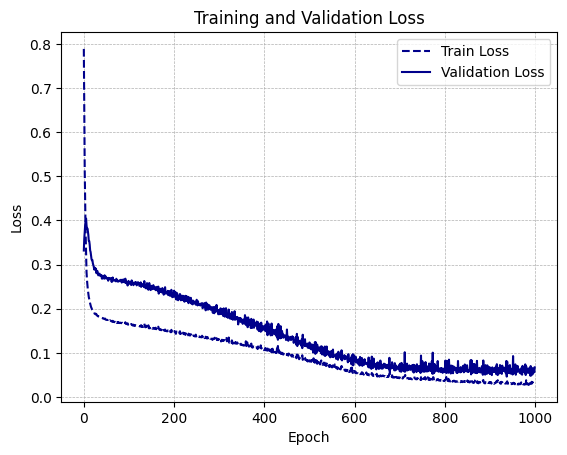

In [246]:
# Printing architectures details
print(f"Hidden layers: {num_layers}")
print(f"Number of hidden features in each node: {hidden_dim}")
print(f"Number of nodes in the graph: {n_nodes}")
print(f"Learning rate: {lr}")
print(f"Optimizer: {optimizer}")

# Average score/error computed from the

plt.plot(total_train_losses, lw=1.5, c='darkblue', label='Train Loss', linestyle='--')
plt.plot(total_val_losses, lw=1.5, c='darkblue', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Reactor: Reactor_9
True sequence shape: torch.Size([8, 2])
Pred shape: torch.Size([8, 2])


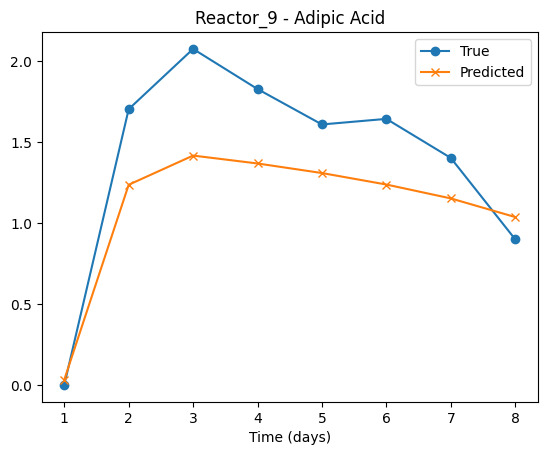

In [253]:
reactor_model.eval()

# Pick one validation sample (e.g., the first one)
graphs, y_true, name = val_dataset[0]

print("Reactor:", name)
print("True sequence shape:", y_true.shape)  # (T, 2)
if not torch.is_tensor(y_true):
    y_true = torch.tensor(y_true, dtype=torch.float32)

device = next(reactor_model.parameters()).device
y_true = y_true.to(device)

graphs = [g.to(device) for g in graphs]   # each timestep graph

with torch.no_grad():
    y_pred = reactor_model(graphs)   # (T, 2)

print("Pred shape:", y_pred.shape)

y_pred_np = y_pred.cpu().numpy()
y_true_np = y_true.cpu().numpy()

T = len(y_pred_np)
time_axis = np.arange(1, T+1)

plt.plot(time_axis, y_true_np[:,0], label="True", marker='o')
plt.plot(time_axis, y_pred_np[:,0], label="Predicted", marker='x')
plt.title(f"{name} - Adipic Acid")
plt.xlabel("Time (days)")
plt.legend()
plt.show()

## Hyperparameter tunning

### Number of nodes and number of GNN layers

Here I will perform a grid search over different number of nodes and depth of the GNN

In [426]:
# K-fold split
k_folds = 8
kf = KFold(n_splits=k_folds, shuffle=True, random_state=RSEED)

# Hyperparameters
n_inputs = len(input_columns)
n_outputs = len(output_columns)
hidden_dim = 32
lr = 1e-4
epochs = 850

# Grid values search
num_layers = [2, 3]
n_nodes = [5, 15, 25, 35]

# For the grid search heatmap
A_heatmap_avg = np.zeros((len(num_layers), len(n_nodes)))
A_heatmap_std = np.zeros((len(num_layers), len(n_nodes)))

for i in range(len(num_layers)):
    for j in range(len(n_nodes)):
        # For saving the final validation loss of each fold
        fold_results = []
        for fold, (train_idx, val_idx) in enumerate(kf.split(range(num_reactors))):
            print(f"----------- Fold: {fold+1}/{k_folds}, Layers: {num_layers[i]}, Nodes: {n_nodes[j]} -----------")

            # Full Dataset
            dataset = ReactorGraphSequenceDataset(df_adip7d, input_columns, output_columns, num_nodes=n_nodes[j])

            # Train-valid Dataset split
            train_subset = torch.utils.data.Subset(dataset, train_idx)
            val_subset = torch.utils.data.Subset(dataset, val_idx)

            # Dataloaders
            train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
            val_loader   = DataLoader(val_subset, batch_size=1, shuffle=False)

            # Build model
            reactor_model = ReactorGNN(n_inputs, hidden_dim, num_layers=num_layers[i]).to(device)
            
            # Loss and optimizer
            loss_function = nn.MSELoss()
            optimizer = torch.optim.Adam(reactor_model.parameters(), lr = lr)

            # Save best model and model performance
            best_val_loss = float('inf')
            best_model_state = None
            best_model_parameters = None

            for epoch in range(epochs):

                # Train the model
                avg_train_loss = train_GNN(train_loader, reactor_model, loss_function, optimizer)

                # Validate the model
                avg_val_loss = validate_GNN(val_loader, reactor_model, loss_function)

                if (epoch+1) % 200 == 0:
                    print(f'Epoch [{epoch+1}/{epochs}]\nTrain Loss: {avg_train_loss:.4f}')
                    print(f'Valid Loss: {avg_val_loss:.4f}\n')

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_state = copy.deepcopy(reactor_model.state_dict())
                best_model_parameters = [num_layers[i], n_nodes[j]]
            
            # Save fold performance over validation set
            fold_results.append(avg_val_loss)
        
        # Compute full CV results and save to the heatmap matrix
        A_heatmap_avg[i,j] = np.mean(fold_results)
        A_heatmap_std[i,j] = np.std(fold_results)

        print(f'Cross validation results [Layers, Nodes] = [{num_layers[i],n_nodes[j]}]')
        print(f"Average validation loss: {np.mean(fold_results):4f} ± {np.std(fold_results):4f}")

----------- Fold: 1/8, Layers: 2, Nodes: 5 -----------
Epoch [200/850]
Train Loss: 0.1528
Valid Loss: 0.2968

Epoch [400/850]
Train Loss: 0.1187
Valid Loss: 0.3004

Epoch [600/850]
Train Loss: 0.0911
Valid Loss: 0.2823

Epoch [800/850]
Train Loss: 0.0687
Valid Loss: 0.2608

----------- Fold: 2/8, Layers: 2, Nodes: 5 -----------
Epoch [200/850]
Train Loss: 0.1601
Valid Loss: 0.2106

Epoch [400/850]
Train Loss: 0.1417
Valid Loss: 0.1495

Epoch [600/850]
Train Loss: 0.1127
Valid Loss: 0.0938

Epoch [800/850]
Train Loss: 0.0666
Valid Loss: 0.0673

----------- Fold: 3/8, Layers: 2, Nodes: 5 -----------
Epoch [200/850]
Train Loss: 0.1646
Valid Loss: 0.3237

Epoch [400/850]
Train Loss: 0.1460
Valid Loss: 0.3333

Epoch [600/850]
Train Loss: 0.1164
Valid Loss: 0.3145

Epoch [800/850]
Train Loss: 0.0973
Valid Loss: 0.3003

----------- Fold: 4/8, Layers: 2, Nodes: 5 -----------
Epoch [200/850]
Train Loss: 0.1510
Valid Loss: 0.3476

Epoch [400/850]
Train Loss: 0.1277
Valid Loss: 0.3385

Epoch [600

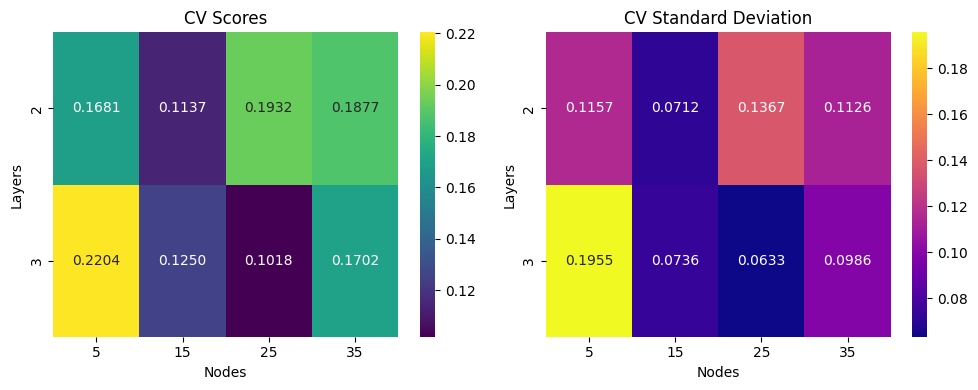

In [428]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Heatmap for CV score values
sns.heatmap(A_heatmap_avg, ax=axes[0], cmap='viridis', annot=True, fmt=".4f", yticklabels=num_layers, xticklabels=n_nodes, cbar=True)
axes[0].set_title("CV Scores")
axes[0].set_ylabel("Layers")
axes[0].set_xlabel("Nodes")

# Heatmap for CV scores standard deviation
sns.heatmap(A_heatmap_std, ax=axes[1], cmap='plasma', annot=True, fmt=".4f", yticklabels=num_layers, xticklabels=n_nodes, cbar=True)
axes[1].set_title("CV Standard Deviation")
axes[1].set_ylabel("Layers")
axes[1].set_xlabel("Nodes")

plt.tight_layout()
plt.show()

We choose to use the hyperparameters `n_nodes = 25` and `num_layers = 3`, since these yield the lowest CV error and standard deviation

### Learning rate and Hidden dimention

In [431]:
# K-fold split
k_folds = 8
kf = KFold(n_splits=k_folds, shuffle=True, random_state=RSEED)

# Hyperparameters
n_inputs = len(input_columns)
n_outputs = len(output_columns)
epochs = 850
n_nodes = 3
num_layers = 25

# Grid values search
l_rates = [1e-4]
hidden_dims = [16, 32, 64]

# For the grid search heatmap
B_heatmap_avg = np.zeros((len(l_rates), len(hidden_dims)))
B_heatmap_std = np.zeros((len(l_rates), len(hidden_dims)))

for i in range(len(l_rates)):
    for j in range(len(hidden_dims)):
        # For saving the final validation loss of each fold
        fold_results = []
        for fold, (train_idx, val_idx) in enumerate(kf.split(range(num_reactors))):
            print(f"----------- Fold: {fold+1}/{k_folds}, Learning rate: {l_rates[i]}, Hidden dimention: {hidden_dims[j]} -----------")

            # Full Dataset
            dataset = ReactorGraphSequenceDataset(df_adip7d, input_columns, output_columns, num_nodes=n_nodes)

            # Train-valid Dataset split
            train_subset = torch.utils.data.Subset(dataset, train_idx)
            val_subset = torch.utils.data.Subset(dataset, val_idx)

            # Dataloaders
            train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
            val_loader   = DataLoader(val_subset, batch_size=1, shuffle=False)

            # Build model
            reactor_model = ReactorGNN(n_inputs, hidden_dims[j], num_layers=num_layers).to(device)
            
            # Loss and optimizer
            loss_function = nn.MSELoss()
            optimizer = torch.optim.Adam(reactor_model.parameters(), lr = l_rates[i])

            # Save best model and model performance
            best_val_loss = float('inf')
            best_model_state = None
            best_model_parameters = None

            for epoch in range(epochs):

                # Train the model
                avg_train_loss = train_GNN(train_loader, reactor_model, loss_function, optimizer)

                # Validate the model
                avg_val_loss = validate_GNN(val_loader, reactor_model, loss_function)

                if (epoch+1) % 200 == 0:
                    print(f'Epoch [{epoch+1}/{epochs}]\nTrain Loss: {avg_train_loss:.4f}')
                    print(f'Valid Loss: {avg_val_loss:.4f}\n')

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_state = copy.deepcopy(reactor_model.state_dict())
                best_model_parameters = [l_rates[i], hidden_dims[j]]
            
            # Save fold performance over validation set
            fold_results.append(avg_val_loss)
        
        # Compute full CV results and save to the heatmap matrix
        B_heatmap_avg[i,j] = np.mean(fold_results)
        B_heatmap_std[i,j] = np.std(fold_results)

        print(f'Cross validation results [Learning rate, Hidden dimention] = [{l_rates[i],hidden_dims[j]}]')
        print(f"Average validation loss: {np.mean(fold_results):4f} ± {np.std(fold_results):4f}")

----------- Fold: 1/8, Learning rate: 0.0001, Hidden dimention: 16 -----------
Epoch [200/850]
Train Loss: 0.1411
Valid Loss: 0.3629

Epoch [400/850]
Train Loss: 0.1191
Valid Loss: 0.4048

Epoch [600/850]
Train Loss: 0.1085
Valid Loss: 0.2559

Epoch [800/850]
Train Loss: 0.0646
Valid Loss: 0.0750

----------- Fold: 2/8, Learning rate: 0.0001, Hidden dimention: 16 -----------
Epoch [200/850]
Train Loss: 0.1726
Valid Loss: 0.1850

Epoch [400/850]
Train Loss: 0.1653
Valid Loss: 0.1765

Epoch [600/850]
Train Loss: 0.1563
Valid Loss: 0.1607

Epoch [800/850]
Train Loss: 0.1108
Valid Loss: 0.1361

----------- Fold: 3/8, Learning rate: 0.0001, Hidden dimention: 16 -----------
Epoch [200/850]
Train Loss: 0.1580
Valid Loss: 0.2650

Epoch [400/850]
Train Loss: 0.1351
Valid Loss: 0.2444

Epoch [600/850]
Train Loss: 0.1279
Valid Loss: 0.2442

Epoch [800/850]
Train Loss: 0.1282
Valid Loss: 0.2418

----------- Fold: 4/8, Learning rate: 0.0001, Hidden dimention: 16 -----------
Epoch [200/850]
Train Lo

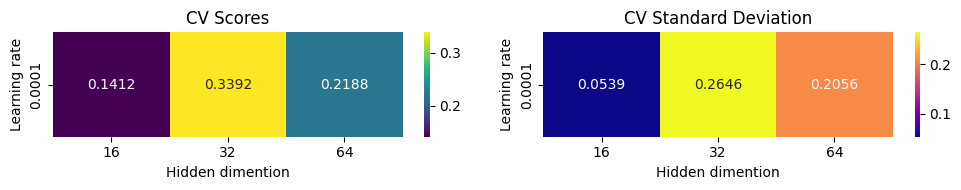

In [439]:
fig, axes = plt.subplots(1, 2, figsize=(10, 2))

# Heatmap for CV score values
sns.heatmap(B_heatmap_avg, ax=axes[0], cmap='viridis', annot=True, fmt=".4f", yticklabels=l_rates, xticklabels=hidden_dims, cbar=True)
axes[0].set_title("CV Scores")
axes[0].set_ylabel("Learning rate")
axes[0].set_xlabel("Hidden dimention")

# Heatmap for CV scores standard deviation
sns.heatmap(B_heatmap_std, ax=axes[1], cmap='plasma', annot=True, fmt=".4f", yticklabels=l_rates, xticklabels=hidden_dims, cbar=True)
axes[1].set_title("CV Standard Deviation")
axes[1].set_ylabel("Learning rate")
axes[1].set_xlabel("Hidden dimention")

plt.tight_layout()
plt.show()

We see an increase in both error and standard deeviation when increasing the hidden dimention. We well keep the hidden dimention small `hidden_dim = 16`. This model showed special instability with the given datates. As you can see here, the CV score for 32 hidden dimention and yields 0.3392, while, before, the equivalent model yielded a much lower 0.1018 error.

We will use as a metric the value of the smalle shidden dimention:

$$\mathbf{CV}_{score} = 0.1412 \pm 0.0539$$

## CV Score of the fine tunned model

In [13]:
reactor_labels = df_adip7d["reactor"].values
unique_reactor_labels = np.unique(reactor_labels) 

# Training of the fine tuned model
kf = KFold(n_splits=8, shuffle=True, random_state=RSEED)
fold_scores = []

# Setting hyperparameters
n_inputs = len(input_columns)
n_outputs = len(output_columns)
hidden_dim = 16
num_layers = 3
n_nodes = 25
lr = 1e-4
epochs = 1000

for train_reactor_idx, val_reactor_idx in kf.split(unique_reactor_labels):
    print('Train-Valid reactor split:')
    print(train_reactor_idx)
    print(val_reactor_idx)

    # Randomly choose the reactors for training and validating
    train_reactors = unique_reactor_labels[train_reactor_idx]
    val_reactors   = unique_reactor_labels[val_reactor_idx]

    # Masks for spliting the reactors
    train_mask = np.isin(reactor_labels, train_reactors)
    val_mask   = np.isin(reactor_labels, val_reactors)

    # Split reactors into train-validation
    train_df = df_adip7d[train_mask]
    val_df = df_adip7d[val_mask]

    # Create train and validation Datasets
    train_dataset = ReactorGraphSequenceDataset(train_df, input_columns, output_columns, num_nodes=5)
    val_dataset   = ReactorGraphSequenceDataset(val_df, input_columns, output_columns, num_nodes=5)

    # Create train and validation Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False)

    # Build fine tuned model
    reactor_model = ReactorGNN(n_inputs, hidden_dim, n_outputs, num_layers).to(device)

    # Loss and optimizer
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(reactor_model.parameters(), lr=lr)

    for epoch in range(epochs):

      # Train the model
      avg_train_loss = train_GNN(train_loader, reactor_model, loss_function, optimizer)

      # Validate the model
      avg_val_loss = validate_GNN(val_loader, reactor_model, loss_function)

      if (epoch+1) % 200 == 0:
        print(f'Epoch {epoch+1}/{epochs}\nTrain Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        print('-------------------------------------')
    fold_scores.append(avg_val_loss)

print(f"Mean MSE: {np.mean(fold_scores)}")
print(f"MSE StanDev: {np.std(fold_scores)}")

Train-Valid reactor split:
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[0 1]
Epoch 200/1000
Train Loss: 0.1918, Val Loss: 0.1473
-------------------------------------
Epoch 400/1000
Train Loss: 0.1696, Val Loss: 0.1361
-------------------------------------
Epoch 600/1000
Train Loss: 0.1500, Val Loss: 0.1330
-------------------------------------
Epoch 800/1000
Train Loss: 0.1223, Val Loss: 0.1390
-------------------------------------
Epoch 1000/1000
Train Loss: 0.0864, Val Loss: 0.1268
-------------------------------------
Train-Valid reactor split:
[ 0  1  2  3  4  6  7  8  9 10 11 12 13 15]
[ 5 14]
Epoch 200/1000
Train Loss: 0.1703, Val Loss: 0.2216
-------------------------------------
Epoch 400/1000
Train Loss: 0.1497, Val Loss: 0.2256
-------------------------------------
Epoch 600/1000
Train Loss: 0.1258, Val Loss: 0.2219
-------------------------------------
Epoch 800/1000
Train Loss: 0.0821, Val Loss: 0.2093
-------------------------------------
Epoch 1000/1000
Train Loss: 0.042

## Plot Adipic Acid prediction

Using the fine-tuned values of the hyperparameters, select a signle train-validation split and visualize the performanc eof adipic acid over time.

In [10]:
reactor_labels = df_adip7d["reactor"].values
unique_reactor_labels = np.unique(reactor_labels) 
train_reactors, val_reactors = train_test_split(unique_reactor_labels, test_size=0.1, random_state=RSEED-1)

# Masks for spliting the reactors
train_mask = np.isin(reactor_labels, train_reactors)
val_mask   = np.isin(reactor_labels, val_reactors)

# Split reactors into train-validation
train_df = df_adip7d[train_mask]
val_df = df_adip7d[val_mask]

# Create train and validation Datasets
train_dataset = ReactorGraphSequenceDataset(train_df, input_columns, output_columns, num_nodes=5)
val_dataset   = ReactorGraphSequenceDataset(val_df, input_columns, output_columns, num_nodes=5)

# Create train and validation Dataloaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Setting hyperparameters
n_inputs = len(input_columns)
n_outputs = len(output_columns)
hidden_dim = 16
num_layers = 3
n_nodes = 25
lr = 1e-4
epochs = 1000

# Build fine tuned model
reactor_model = ReactorGNN(n_inputs, hidden_dim, n_outputs, num_layers).to(device)

# Loss and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(reactor_model.parameters(), lr=lr)

# Train and validate
total_train_losses = []
total_val_losses   = []

start_time = time.time()
for epoch in range(epochs):

  # Train the model
  avg_train_loss = train_GNN(train_loader, reactor_model, loss_function, optimizer)

  # Validate the model
  avg_val_loss = validate_GNN(val_loader, reactor_model, loss_function)

  # Save losses values
  total_train_losses.append(avg_train_loss)
  total_val_losses.append(avg_val_loss)

  if (epoch+1) % 200 == 0:
    print(f'Epoch {epoch+1}/{epochs}\nTrain Loss: {total_train_losses[-1]:.4f}, Val Loss: {total_val_losses[-1]:.4f}')
    print('-------------------------------------')

training_time = time.time() - start_time
print(f"Total training time: {training_time} seconds")

Epoch 200/1000
Train Loss: 0.1704, Val Loss: 0.2646
-------------------------------------
Epoch 400/1000
Train Loss: 0.1560, Val Loss: 0.2687
-------------------------------------
Epoch 600/1000
Train Loss: 0.1329, Val Loss: 0.2471
-------------------------------------
Epoch 800/1000
Train Loss: 0.0821, Val Loss: 0.2185
-------------------------------------
Epoch 1000/1000
Train Loss: 0.0623, Val Loss: 0.1621
-------------------------------------
Total training time: 131.3786849975586 seconds


Reactor: Reactor_3
True sequence shape: torch.Size([8, 2])
Pred shape: torch.Size([8, 2])


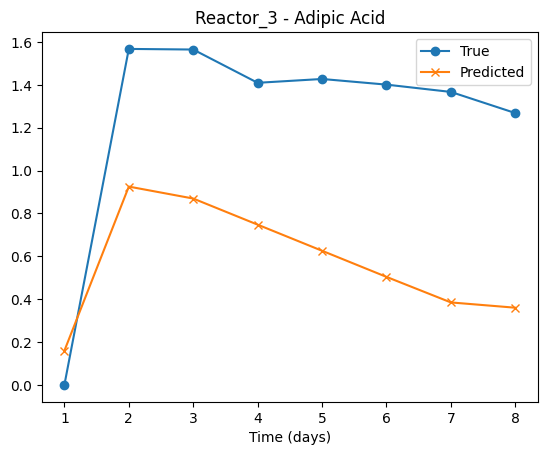

In [461]:
reactor_model.eval()

# Pick one validation sample (e.g., the first one)
graphs, y_true, name = val_dataset[1]

print("Reactor:", name)
print("True sequence shape:", y_true.shape)  # (T, 2)
if not torch.is_tensor(y_true):
    y_true = torch.tensor(y_true, dtype=torch.float32)

device = next(reactor_model.parameters()).device
y_true = y_true.to(device)

graphs = [g.to(device) for g in graphs]   # each timestep graph

with torch.no_grad():
    y_pred = reactor_model(graphs)   # (T, 2)

print("Pred shape:", y_pred.shape)

y_pred_np = y_pred.cpu().numpy()
y_true_np = y_true.cpu().numpy()

T = len(y_pred_np)
time_axis = np.arange(1, T+1)

plt.plot(time_axis, y_true_np[:,0], label="True", marker='o')
plt.plot(time_axis, y_pred_np[:,0], label="Predicted", marker='x')
plt.title(f"{name} - Adipic Acid")
plt.xlabel("Time (days)")
plt.legend();

In [464]:
# Save predicted data in a numpy array
np.save('AdipPred-GNN-Reactor_3.npy', y_pred_np[:,0])